In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
#%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
#from sklearn.manifold import TSNE
#from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
#from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
#import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

from tqdm import tqdm
import time
from sklearn import preprocessing
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import torch
from torch import nn, optim
import torch.nn.functional as F

# Загрузка датасета

In [2]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

In [3]:
data_path = './training.1600000.processed.noemoticon.csv'
df = pd.read_csv(data_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [4]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [6]:
df.head(10)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Предобработка

In [8]:
decode_map = {0: -1, 2: 0, 4: 1}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
df.target = df.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset labels distribuition')

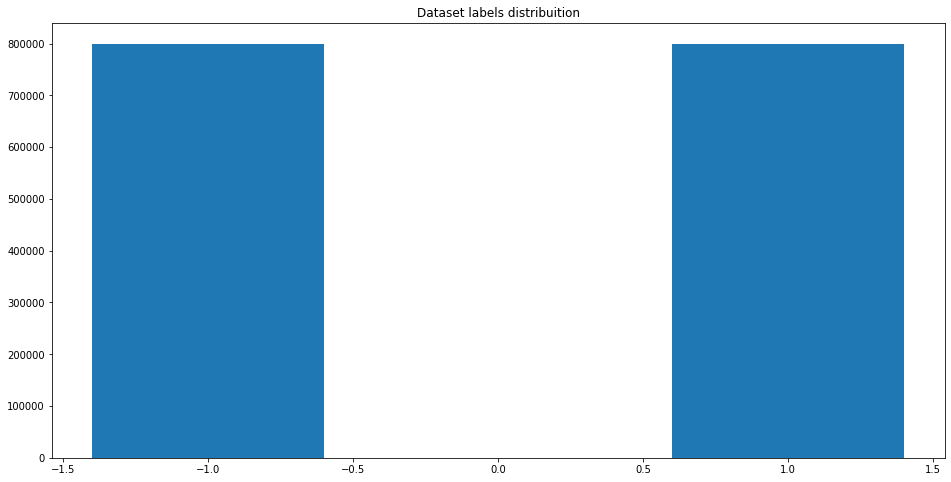

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Удаляем ненужные столбцы и уменьшаем выборку потому что мы не хотим сидеть ждать неделю на каждом запуске

In [11]:
#data = df[:10000]
data = df.sample(frac=1)
data = data[:50000]
data = data.drop(['ids', 'date', 'flag', 'user'], axis = 1)
data = data.reset_index(drop=True)
data

,target,text
0,1,Long night! Now off to rise
1,1,@melisadisti u're welcome
2,-1,there are only few guys that can be called as ...
3,-1,I just had a tampon in for 12 hours... I passe...
4,1,playing Left 4 dead in the dark
...,...,...
49995,-1,uragh I feel like crap. ...going to go try an...
49996,1,Eating crabs. Yum.
49997,1,Zoo with everett
49998,-1,absolute thumping headache coming on thats ne...


In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stopwords = stopwords.words('english')

In [14]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [15]:
data_news = df.reset_index(drop=True)

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
def lemmatize_df(df, stopwords, column):
    lemmatizer = WordNetLemmatizer()
    for i in range(len(df[column])):
        temp_string = ""
        for word in df[column][i].split():
            word = ("".join(e for e in word if e.isalnum()))
            word = word.lower()
            word = lemmatizer.lemmatize(word)
            if not word in stopwords:
                temp_string += word + " "  
            
        df.at[i,column] = temp_string.strip()
    return df

In [18]:
lemmatized_data_tweets = lemmatize_df(data, stopwords, 'text')

In [19]:
lemmatized_data_tweets

,target,text
0,1,long night rise
1,1,melisadisti ure welcome
2,-1,guy called gentleman
3,-1,tampon 12 hour passed nobody woke upnow cant e...
4,1,playing left 4 dead dark
...,...,...
49995,-1,uragh feel like crap going go try sleep
49996,1,eating crab yum
49997,1,zoo everett
49998,-1,absolute thumping headache coming thats never ...


In [20]:
tweets_copy = lemmatized_data_tweets.copy()
encoders = {}

encoder = preprocessing.LabelEncoder()
encoder.fit(tweets_copy["target"])
tweets_copy["target"] = encoder.transform(tweets_copy["target"])
encoders["target"] = encoder

In [21]:
df_train, df_test = train_test_split(data, test_size=1-0.8, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 40000
TEST size: 10000


In [22]:
data_split = tweets_copy.copy()
y = data_split['target'].values
x = data_split.drop(['target'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)
vect = CountVectorizer(min_df=10)

In [23]:
X_train_review_bow = vect.fit_transform(list(X_train['text'])).toarray()
X_test_review_bow = vect.transform(X_test['text']).toarray()

In [24]:
def test_model(model, X_test, Y_test):
    counter = 0
    y_test_len = len(Y_test)

    with torch.no_grad():
        for i,data in enumerate(X_test):
            y_val = model.forward(data)
            if y_val.argmax().item() == Y_test[i]:
                counter += 1
    print(f'{counter} out of {y_test_len} = {100*counter/y_test_len:.2f}% right')

In [25]:
X_train = torch.Tensor(X_train_review_bow)
Y_train = torch.LongTensor(Y_train)
X_test = torch.Tensor(X_test_review_bow)
Y_test = torch.LongTensor(Y_test)

In [26]:
len_vector = X_train_review_bow.shape[1]
len_vector

3110

# Модели
Модель 1

In [27]:
model = nn.Sequential(
        nn.Linear(len_vector, 10000),
        nn.Linear(10000, 1000),
        nn.Linear(1000, 100),
        nn.Linear(100, 10),
        nn.Sigmoid())


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [29]:
epochs = 10
potracheno = []
for i in range(epochs):
    i += 1
    Y_pred = model.forward(X_train)
    loss = criterion(Y_pred, Y_train)
    potracheno.append(loss)

    print(f'Эпоха:{i} потрачено:{loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Эпоха:1 потрачено:2.30310583
Эпоха:2 потрачено:1.79631388
Эпоха:3 потрачено:1.59803796
Эпоха:4 потрачено:1.59798026
Эпоха:5 потрачено:1.59798002
Эпоха:6 потрачено:1.59798002
Эпоха:7 потрачено:1.59798002
Эпоха:8 потрачено:1.59798002
Эпоха:9 потрачено:1.59798002
Эпоха:10 потрачено:1.59798002


In [30]:
counter = 0
y_test_len = len(Y_test)
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
        if y_val.argmax().item() == Y_test[i]:
            counter += 1
print(f'{counter} из {y_test_len} = {100*counter/y_test_len:.2f}% угадано')

5114 из 10000 = 51.14% угадано


Модель 2

In [31]:
model2 = nn.Sequential(
        nn.Linear(len_vector, 1488),
        nn.ReLU(),
        nn.Linear(1488, 69),
        nn.Sigmoid())

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)

In [33]:
epochs = 10
potracheno = []
for i in range(epochs):
    i += 1
    Y_pred = model2.forward(X_train)
    loss = criterion(Y_pred, Y_train)
    potracheno.append(loss)

    print(f'Эпоха:{i} потрачено:{loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Эпоха:1 потрачено:4.23605251
Эпоха:2 потрачено:3.93128824
Эпоха:3 потрачено:3.56377530
Эпоха:4 потрачено:3.36863565
Эпоха:5 потрачено:3.30928469
Эпоха:6 потрачено:3.29214716
Эпоха:7 потрачено:3.28656363
Эпоха:8 потрачено:3.28446054
Эпоха:9 потрачено:3.28356767
Эпоха:10 потрачено:3.28315425


In [34]:
counter = 0
y_test_len = len(Y_test)
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model2.forward(data)
        if y_val.argmax().item() == Y_test[i]:
            counter += 1
print(f'{counter} из {y_test_len} = {100*counter/y_test_len:.2f}% угадано')

5664 из 10000 = 56.64% угадано
